<a href="https://colab.research.google.com/github/Krishnakanth1993/Learnings/blob/main/MNIST_Model/Reference/minimal_prameter_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
from io import StringIO
import sys

In [11]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


# **Understanding the Data**

In [12]:
# Load MNIST training data without normalization
train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=1024, shuffle=False)

# Compute mean and std
mean = 0.0
std = 0.0
total_images = 0

for images, _ in train_loader:
    batch_samples = images.size(0)  # Number of images in batch
    images = images.view(batch_samples, -1)  # Flatten: [batch_size, 1, 28, 28] -> [batch_size, 784]
    mean += images.mean(dim=1).sum().item()  # Sum mean across pixels for each image
    std += images.std(dim=1).sum().item()  # Sum std across pixels for each image
    total_images += batch_samples

mean /= total_images
std /= total_images

print(f'Mean: {mean:.4f}, Std: {std:.4f} ,Total_images: {total_images}')

100%|██████████| 9.91M/9.91M [00:01<00:00, 9.47MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.54MB/s]


Mean: 0.1307, Std: 0.3015 ,Total_images: 60000


In [13]:
dataloader_iterator = iter(train_loader)
batch_data = next(dataloader_iterator)

for item in batch_data:
  if isinstance(item, torch.Tensor):
      #print(item)
      print(f"Shape of a tensor in the batch: {item.shape}")
  else:
      #print(item)
      print(f"Type of item in batch: {type(item)}")

Shape of a tensor in the batch: torch.Size([1024, 1, 28, 28])
Shape of a tensor in the batch: torch.Size([1024])


# **Data Loading & Preprocessing**

In [14]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

val_transforms = transforms.Compose([
    transforms.ToTensor(),  # Only ToTensor for validation
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1407,), (0.4081,)) # Mean: 0.1307, Std: 0.3015 ,Total_images: 60000 . Normalization must be uniform between train and test.
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

In [15]:
full_train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
#Split the full train dataset into train and validate (e.g., 50k train, 10k validate)
train_size = 50000
val_size = len(full_train_data) - train_size  # 10000
train_data, val_data = random_split(full_train_data, [train_size, val_size])

# Set a seed for reproducibility (optional)
torch.manual_seed(42)  # Apply before split if you want consistent results

# Apply validation transforms to val_dataset (workaround since random_split inherits train_transforms)
val_data.dataset.transform = val_transforms


test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [16]:
batch_size = 1024

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
val_loader = torch.utils.data.DataLoader(val_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [17]:
print(f"Length of Train dataset:{len(train_loader.dataset)}")
print(f"Length of Validation dataset:{len(val_loader.dataset)}")
print(f"Length of Test dataset:{len(test_loader.dataset)}")

Length of Train dataset:50000
Length of Validation dataset:10000
Length of Test dataset:10000


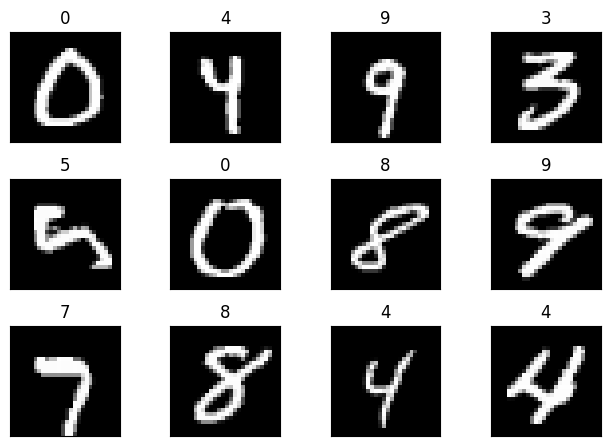

In [18]:
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

# **Model Architecture**

In [29]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self, dropout_p=0.5):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 14, kernel_size=3, padding=1) #28x28x1  | (3x3x1)14 | 28x28x14 RF 3x3
        self.bn1 = nn.BatchNorm2d(14)
        self.conv2 = nn.Conv2d(14, 14, kernel_size=3, padding=1) #28x28x14 | (3x3x14)x14 | 28x28x14 RF 5x5
        self.bn2 = nn.BatchNorm2d(14)
        self.conv3 = nn.Conv2d(14, 14, kernel_size=3, padding=1) #28x28x14 | (3x3x14)x14 | 28x28x14 RF 7x7
        self.bn3 = nn.BatchNorm2d(14)
        self.conv4 = nn.Conv2d(14, 24, kernel_size=3, padding=1) #14x14x14  | (3x3x14)x24 | 14x14x24 RF 12x12
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(24,24, kernel_size=3, padding=1) #7x7x16  | (3x3x16)x8 | 7x7x8 RF 24x24
        self.bn5 = nn.BatchNorm2d(24)
        self.conv6 = nn.Conv2d(24, 16, kernel_size=3, padding=1) #7x7x8 | (3x3x8)x8 | 7x7x8 RF 26x26
        self.bn6 = nn.BatchNorm2d(16)
        self.conv7 = nn.Conv2d(16, 16, kernel_size=3, padding=1) #7x7x8 | (3x3x8)x8 | 7x7x8 RF 28x28
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(p=dropout_p)  # Dropout layer
        self.fc0 = nn.Linear(16, 50)
        self.fc1 = nn.Linear(50, 10) #RF 28x28

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.relu(self.bn4(self.conv4(x)))
        x = torch.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.relu(self.bn6(self.conv6(x)))
        x = torch.relu(self.bn7(self.conv7(x)))
        #x = self.conv8(x)
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])  # Global average pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = torch.relu(self.fc0(x))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

# Get total parameter count dynamically from summary output

# Capture the summary output
old_stdout = sys.stdout
sys.stdout = captured_output = StringIO()
summary(model, input_size=(1, 28, 28))
sys.stdout = old_stdout

summary_text = captured_output.getvalue()

# Parse the summary text to find the total parameters
total_params_line = [line for line in summary_text.splitlines() if "Total params:" in line]
if total_params_line:
    total_params_str = total_params_line[0].split(":")[1].strip().replace(",", "")
    total_params = int(total_params_str)
else:
    # Fallback to manual calculation if parsing fails
    total_params = sum(p.numel() for p in model.parameters())


# Check for Batch Normalization
has_batchnorm = any(isinstance(module, nn.BatchNorm2d) for module in model.modules())

# Check for Dropout
has_dropout = any(isinstance(module, nn.Dropout) for module in model.modules())

# Check for Fully Connected Layer or Global Average Pooling
has_fc = any(isinstance(module, nn.Linear) for module in model.modules())
has_gap = any(isinstance(module, nn.AvgPool2d) or isinstance(module, nn.AdaptiveAvgPool2d) for module in model.modules())

print("## Model Details\n")
print(f"- Total Parameter Count: {total_params}\n")
print(f"- Use of Batch Normalization: {'Yes' if has_batchnorm else 'No'}\n")
print(f"- Use of Dropout: {'Yes' if has_dropout else 'No'}\n")
print(f"- Use of a Fully Connected Layer or Global Average Pooling: {'Yes' if has_fc or has_gap else 'No'}\n")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 28, 28]             140
       BatchNorm2d-2           [-1, 14, 28, 28]              28
            Conv2d-3           [-1, 14, 28, 28]           1,778
       BatchNorm2d-4           [-1, 14, 28, 28]              28
            Conv2d-5           [-1, 14, 28, 28]           1,778
       BatchNorm2d-6           [-1, 14, 28, 28]              28
           Dropout-7           [-1, 14, 14, 14]               0
            Conv2d-8           [-1, 24, 14, 14]           3,048
       BatchNorm2d-9           [-1, 24, 14, 14]              48
           Conv2d-10           [-1, 24, 14, 14]           5,208
      BatchNorm2d-11           [-1, 24, 14, 14]              48
          Dropout-12             [-1, 24, 7, 7]               0
           Conv2d-13             [-1, 16, 7, 7]           3,472
      BatchNorm2d-14             [-1, 1

# Training Setup

In [22]:
# Data to plot accuracy and loss graphs
train_losses = []
validation_losses = []
test_losses = []
train_acc = []
validation_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [23]:
# Define GetCorrectPredCount
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

# Training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)  # Shape: [batch_size]
        train_loss += loss.sum().item()  # Sum per-sample losses for reporting
        loss = loss.mean()  # Average for backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc=f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader.dataset))  # Average per sample

# Generalized evaluation function for validation or testing
def evaluate(model, device, loader, criterion, set_name="Test", losses=None, accuracies=None):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = len(loader.dataset)

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)  # Per-sample loss
            total_loss += loss.sum().item()  # Sum per-sample losses
            correct += GetCorrectPredCount(output, target)

    avg_loss = total_loss / total_samples
    accuracy = 100. * correct / total_samples

    # Store metrics if lists are provided
    if losses is not None:
        losses.append(avg_loss)
    if accuracies is not None:
        accuracies.append(accuracy)

    print(f'{set_name} set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total_samples} ({accuracy:.2f}%)')

    return avg_loss, accuracy

In [30]:
# Setup
print (model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dropout_p = 0.1).to(device)
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.05)
#optimizer = optim.SGD(model.parameters(), lr=0.001 , momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
num_epoch = 20
# Training loop for 10 epochs
for epoch in range(1, num_epoch+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, criterion)
    # Validate after each epoch
    evaluate(model, device, val_loader, criterion, set_name="Validation", losses=validation_losses, accuracies=validation_acc)
    scheduler.step()
    # Test at the end
    evaluate(model, device, test_loader, criterion, set_name="Test", losses=test_losses, accuracies=test_acc)

Net(
  (conv1): Conv2d(1, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(14, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(14, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(14, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(24, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Train: Loss=0.4057 Batch_id=48 Accuracy=58.38: 100%|██████████| 49/49 [00:09<00:00,  5.14it/s]


Validation set: Average loss: 3.3996, Accuracy: 3834/10000 (38.34%)
Test set: Average loss: 3.2811, Accuracy: 3926/10000 (39.26%)
Epoch 2


Train: Loss=0.1554 Batch_id=48 Accuracy=93.19: 100%|██████████| 49/49 [00:09<00:00,  5.08it/s]


Validation set: Average loss: 0.1374, Accuracy: 9589/10000 (95.89%)
Test set: Average loss: 0.1208, Accuracy: 9629/10000 (96.29%)
Epoch 3


Train: Loss=0.1080 Batch_id=48 Accuracy=96.54: 100%|██████████| 49/49 [00:09<00:00,  4.93it/s]


Validation set: Average loss: 0.0693, Accuracy: 9793/10000 (97.93%)
Test set: Average loss: 0.0598, Accuracy: 9821/10000 (98.21%)
Epoch 4


Train: Loss=0.1179 Batch_id=48 Accuracy=97.18: 100%|██████████| 49/49 [00:10<00:00,  4.70it/s]


Validation set: Average loss: 0.0685, Accuracy: 9784/10000 (97.84%)
Test set: Average loss: 0.0597, Accuracy: 9812/10000 (98.12%)
Epoch 5


Train: Loss=0.0576 Batch_id=48 Accuracy=97.65: 100%|██████████| 49/49 [00:10<00:00,  4.72it/s]


Validation set: Average loss: 0.1068, Accuracy: 9705/10000 (97.05%)
Test set: Average loss: 0.0857, Accuracy: 9751/10000 (97.51%)
Epoch 6


Train: Loss=0.0670 Batch_id=48 Accuracy=97.97: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


Validation set: Average loss: 0.0419, Accuracy: 9882/10000 (98.82%)
Test set: Average loss: 0.0472, Accuracy: 9859/10000 (98.59%)
Epoch 7


Train: Loss=0.0482 Batch_id=48 Accuracy=98.14: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


Validation set: Average loss: 0.0468, Accuracy: 9867/10000 (98.67%)
Test set: Average loss: 0.0507, Accuracy: 9855/10000 (98.55%)
Epoch 8


Train: Loss=0.0897 Batch_id=48 Accuracy=98.14: 100%|██████████| 49/49 [00:10<00:00,  4.80it/s]


Validation set: Average loss: 0.0367, Accuracy: 9890/10000 (98.90%)
Test set: Average loss: 0.0346, Accuracy: 9892/10000 (98.92%)
Epoch 9


Train: Loss=0.0440 Batch_id=48 Accuracy=98.49: 100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


Validation set: Average loss: 0.0660, Accuracy: 9813/10000 (98.13%)
Test set: Average loss: 0.0627, Accuracy: 9817/10000 (98.17%)
Epoch 10


Train: Loss=0.0536 Batch_id=48 Accuracy=98.46: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


Validation set: Average loss: 0.0282, Accuracy: 9920/10000 (99.20%)
Test set: Average loss: 0.0302, Accuracy: 9906/10000 (99.06%)
Epoch 11


Train: Loss=0.0511 Batch_id=48 Accuracy=98.92: 100%|██████████| 49/49 [00:09<00:00,  4.97it/s]


Validation set: Average loss: 0.0234, Accuracy: 9938/10000 (99.38%)
Test set: Average loss: 0.0215, Accuracy: 9938/10000 (99.38%)
Epoch 12


Train: Loss=0.0289 Batch_id=48 Accuracy=99.10: 100%|██████████| 49/49 [00:09<00:00,  5.09it/s]


Validation set: Average loss: 0.0227, Accuracy: 9930/10000 (99.30%)
Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)
Epoch 13


Train: Loss=0.0304 Batch_id=48 Accuracy=99.15: 100%|██████████| 49/49 [00:08<00:00,  5.48it/s]


Validation set: Average loss: 0.0224, Accuracy: 9936/10000 (99.36%)
Test set: Average loss: 0.0213, Accuracy: 9941/10000 (99.41%)
Epoch 14


Train: Loss=0.0274 Batch_id=48 Accuracy=99.17: 100%|██████████| 49/49 [00:09<00:00,  5.39it/s]


Validation set: Average loss: 0.0216, Accuracy: 9938/10000 (99.38%)
Test set: Average loss: 0.0202, Accuracy: 9949/10000 (99.49%)
Epoch 15


Train: Loss=0.0249 Batch_id=48 Accuracy=99.20: 100%|██████████| 49/49 [00:09<00:00,  5.37it/s]


Validation set: Average loss: 0.0217, Accuracy: 9941/10000 (99.41%)
Test set: Average loss: 0.0216, Accuracy: 9937/10000 (99.37%)
Epoch 16


Train: Loss=0.0188 Batch_id=48 Accuracy=99.25: 100%|██████████| 49/49 [00:09<00:00,  5.28it/s]


Validation set: Average loss: 0.0210, Accuracy: 9940/10000 (99.40%)
Test set: Average loss: 0.0204, Accuracy: 9941/10000 (99.41%)
Epoch 17


Train: Loss=0.0364 Batch_id=48 Accuracy=99.27: 100%|██████████| 49/49 [00:10<00:00,  4.89it/s]


Validation set: Average loss: 0.0230, Accuracy: 9941/10000 (99.41%)
Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)
Epoch 18


Train: Loss=0.0154 Batch_id=48 Accuracy=99.25: 100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


Validation set: Average loss: 0.0221, Accuracy: 9937/10000 (99.37%)
Test set: Average loss: 0.0216, Accuracy: 9941/10000 (99.41%)
Epoch 19


Train: Loss=0.0190 Batch_id=48 Accuracy=99.32: 100%|██████████| 49/49 [00:10<00:00,  4.81it/s]


Validation set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)
Test set: Average loss: 0.0214, Accuracy: 9940/10000 (99.40%)
Epoch 20


Train: Loss=0.0374 Batch_id=48 Accuracy=99.32: 100%|██████████| 49/49 [00:09<00:00,  5.00it/s]


Validation set: Average loss: 0.0211, Accuracy: 9943/10000 (99.43%)
Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)


# Test Results

Text(0.5, 1.0, 'Validation Accuracy')

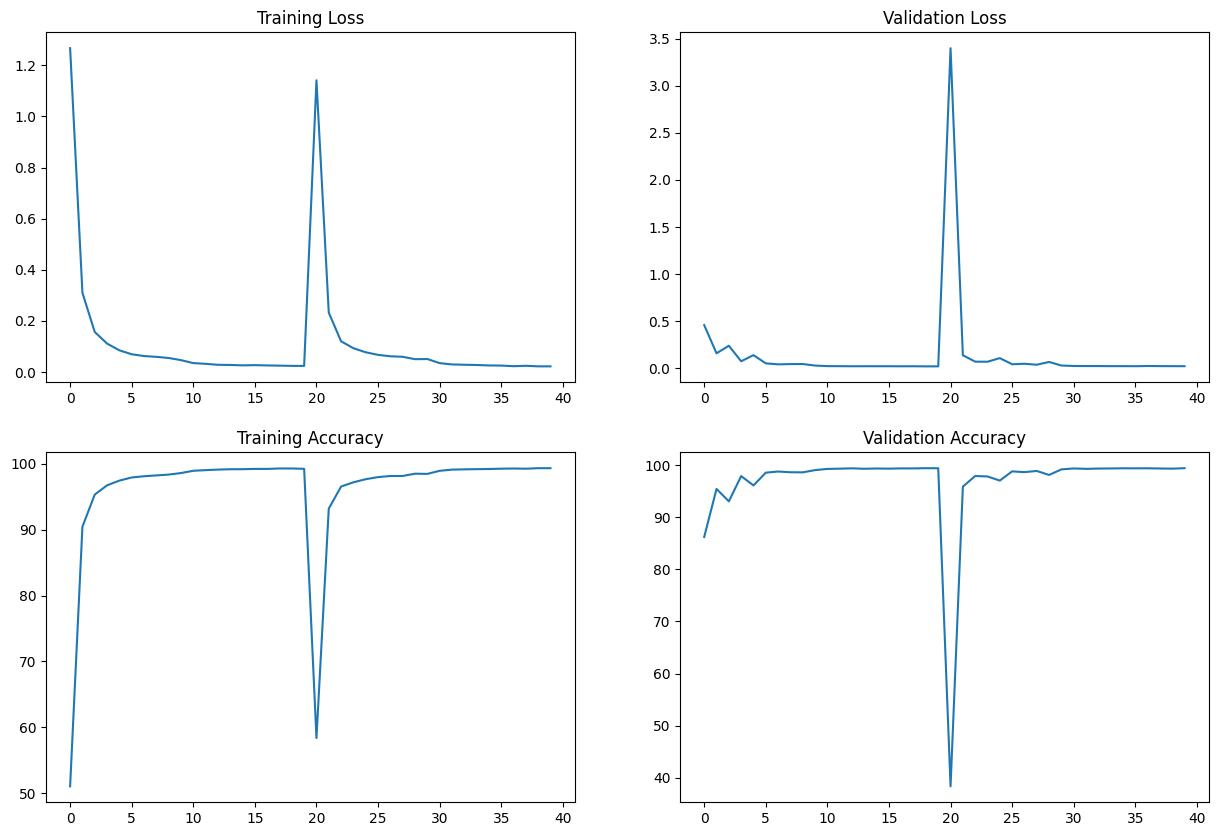

In [31]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(validation_losses)
axs[0, 1].set_title("Validation Loss")
axs[1, 1].plot(validation_acc)
axs[1, 1].set_title("Validation Accuracy")


In [ ]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 28, 28]             280
       BatchNorm2d-2           [-1, 28, 28, 28]              56
            Conv2d-3           [-1, 28, 28, 28]           7,084
       BatchNorm2d-4           [-1, 28, 28, 28]              56
           Dropout-5           [-1, 28, 14, 14]               0
            Conv2d-6           [-1, 16, 14, 14]           4,048
       BatchNorm2d-7           [-1, 16, 14, 14]              32
            Conv2d-8           [-1, 16, 14, 14]           2,320
       BatchNorm2d-9           [-1, 16, 14, 14]              32
          Dropout-10             [-1, 16, 7, 7]               0
           Conv2d-11              [-1, 8, 7, 7]           1,160
      BatchNorm2d-12              [-1, 8, 7, 7]              16
           Conv2d-13              [-1, 8, 7, 7]             584
      BatchNorm2d-14              [-1, 

# Save and Visualize Model

In [ ]:
torch.save(model, "model.pt") ## does not include details of activation functions

In [ ]:
!pip install onnx
device = torch.device("cuda" if use_cuda else "cpu")

# Create dummy input with the same shape as your input
dummy_input = torch.randn(1, 1, 28, 28).to(device)  # Batch x Channels x Height x Width

# Export the model
torch.onnx.export(model, dummy_input, "model.onnx",
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
                  opset_version=11)

/tmp/ipython-input-3254252982.py:7: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, dummy_input, "model.onnx",


In [ ]:
model

Net(
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(28, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dr

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 62.4 MB/s eta 0:00:00
